# Problem Statement: HW4_SankalpSingh

## IST707: Data Analytics: HW4: Statistical Learning, Deep Learning and A Complete Comparison

## Date of Submission: 11/25/2020

### In this homework assignment, we are going to use multiple machine learning algorithms, including logistic regression, multiple artificial neural networks and deep learning models with different architectures to build disease diagnosis models using the same dataset in HW3. It is a binary classification problem to predict whether or not a patient has a certain unspecified disease. You also need to combine the findings with HW3 results to come up with a ranking of performance for various machine learning models on this dataset.

### Information about the dataset (Disease Prediction Training.csv):

• Age: in years

• Gender: male/female

• Height: in unit of cm

• Weight: in unit of kg

• Low Blood Pressure: lower bound of blood pressure measurement

• High Blood Pressure: higher bound of blood pressure measurement

• Cholesterol: three cholesteral levels

• Glucose: three glucose levels

• Smoke: 1/0 regarding if the patient smokes

• Alcohol: 1/0 regarding if the patient drinks alcohol

• Exercise: 1/0 regarding if the patient exercises regularly

• Disease: The binary target variable. Does the patient have the disease?


### Import Libraries

Importing all the required libraries that will help us perform data pre-processing, visualizations, modeling and performance evaluation.

In [1]:
# importing all the required libraries
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from pandas import DataFrame, Series
import seaborn as sns
from fancyimpute import IterativeImputer
from scipy import stats
from sklearn import preprocessing
from scipy.spatial import distance_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, ShuffleSplit, LeaveOneOut
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score,classification_report,recall_score,roc_curve,roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
import pickle
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import random as rn
import os
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
rn.seed(12345)
from keras import backend as K
from collections import OrderedDict

Using TensorFlow backend.


### Read dataset

- Here we are reading both the train and test data set. We will be performing all the data pre-processing steps on both the training and testing data set. 

- Later on, while modeling we will be splitting the training dataset into training and validation to train our model and perform hyper parameter tuning using the performance on validation set. 

- Finally, we will be using the model with best parameters to predict binary labels on the testing dataset.


In [2]:
# Reading both training and testing dataset
df=pd.read_csv('Disease Prediction Training.csv')
test_df = pd.read_csv('Disease Prediction Testing.csv')

In [3]:
# Check the shape of the train data
df.shape

(49000, 12)

In [4]:
# Check the shape of the test data
test_df.shape

(21000, 12)

In [5]:
# View first few data points of training data
df.head()

,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease
0,59,female,167,88.0,130,68,normal,normal,0,0,1,0
1,64,female,150,71.0,140,100,normal,normal,0,0,0,1
2,41,female,166,83.0,100,70,normal,normal,0,1,1,0
3,50,male,172,110.0,130,80,normal,normal,1,0,1,0
4,39,female,162,61.0,110,80,high,high,0,0,1,0


In [6]:
# Check the data type for each of the attributes of training data
df.dtypes

Age                      int64
Gender                  object
Height                   int64
Weight                 float64
High Blood Pressure      int64
Low Blood Pressure       int64
Cholesterol             object
Glucose                 object
Smoke                    int64
Alcohol                  int64
Exercise                 int64
Disease                  int64
dtype: object

## Data Pre-processing & Exploratory Data Analysis

#### Here, we have followed the CRISP-DM methodology  which consists of following steps in the mentioned order: Business & Data Understanding -> Data cleaning & Pre-processing -> Modeling -> Performance Evaluation 

We have addressed the following data issues here while performing the data pre-processing:

1) Check for Null values

2) Handling outliers

3) Feature Engineering

4) Data Transformations


### 1) Checking for null values in train and test set

- Here, we can see that both our train and test data does not contain any null or missing values

In [7]:
# Check total null values present for all attributes in training data
df.isnull().sum()

Age                    0
Gender                 0
Height                 0
Weight                 0
High Blood Pressure    0
Low Blood Pressure     0
Cholesterol            0
Glucose                0
Smoke                  0
Alcohol                0
Exercise               0
Disease                0
dtype: int64

In [8]:
# Check total null values present for all attributes in testing data
test_df.isnull().sum()

ID                     0
Age                    0
Gender                 0
Height                 0
Weight                 0
High Blood Pressure    0
Low Blood Pressure     0
Cholesterol            0
Glucose                0
Smoke                  0
Alcohol                0
Exercise               0
dtype: int64

### Check for distribution of labels for the target attribute

-  We can see from the distribution plot below that our training data contains almost equal number of data points for both the binary labels in our target attribute: 'Disease' - 1(Disease) / 0(No Disease)

Text(0.5, 1.0, 'Distribution of Disease for our dataset')

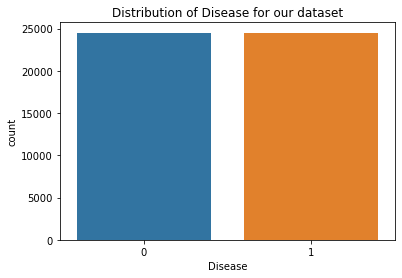

In [9]:
# Countplot to check the distribution of labels in attribute - 'Disease'
sns.countplot(x="Disease", data=df).set_title('Distribution of Disease for our dataset')

### 2) Handling outliers

- Checking for outliers in the data set and treating them accordingly is one of the major steps of pre-processing in order to achieve a higher model performance

- Below we have plotted the boxplots for our various features Vs target attribute 'Disease' to check if our numerical attributes contain any outliers

- We have used the clipping technique to deal with the outliers present in our dataset. Clipping technique involves checking for all the values present in an attribute and identifying which all values lie outside the range that we have provided for clipping

- We have clipped the outliers according to what is considered as the general lower and upper limit for each of the attributes in the medical domain. All the lower and upper limit values for each of the attributes will be clipped according to the values we have provided in the clip function

- We have clipped the values for following features - 'Height', 'Weight', 'High Blood Pressure', 'Low Blood Pressure'



#### Height

- We can see from the below boxplot that the 'Height' feature contains outliers

- The upper limit for the height variable seems to be fine

- The lower limit for the height variable is 55cm. It is highly unlikely for patients to have a height of 55cm given that the minimum Age of patients in our dataset is 29 years

- So, we have clipped the lower limit of Height variable to 100cm

Minimum height: 55
Maximum height: 207


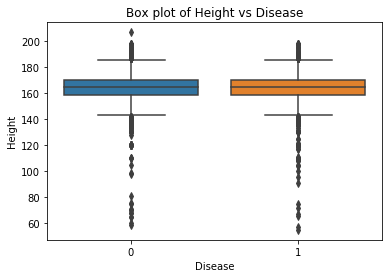

In [10]:
# Boxplot of Height attribute vs target attribute Disease
sns.boxplot(y="Height", x="Disease", data=df)
plt.title("Box plot of Height vs Disease")

# printing max and min height
print('Minimum height:', min(df['Height']))
print('Maximum height:', max(df['Height']))

In [11]:
# Clipping lower limit of height for both train and test data
df['Height'] = df["Height"].clip(lower=100)
test_df['Height'] = test_df['Height'].clip(lower=100)

#### Weight

- We can see from the below boxplot that the 'Weight' feature contains outliers
- The upper limit for the weight variable seems to be fine
- The lower limit for the weight variable is 10kg. It is highly unlikely for patients to have a weight of 10kg given that the minimum Age of patients in our dataset is 29 years
- So, we have clipped the lower limit of Weight variable to 30kg

Maximum Weight: 200.0
Minimum Weight: 10.0


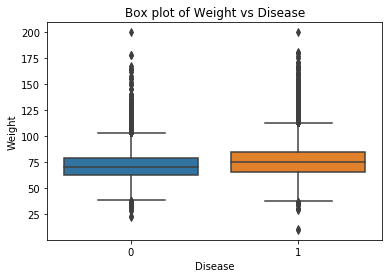

In [12]:
# Boxplot of Weight attribute vs target attribute Disease
sns.boxplot(y="Weight", x="Disease", data=df)
plt.title("Box plot of Weight vs Disease")

# printing max and min weight
print('Maximum Weight:', max(df['Weight']))
print('Minimum Weight:', min(df['Weight']))

In [13]:
# clipping the lower limit for Weight for both the train and test data
df['Weight'] = df["Weight"].clip(lower=30)
test_df['Weight'] = test_df['Weight'].clip(lower=30)

#### High Blood Pressure

- We can see from the below boxplot that the 'High Blood Pressure' feature contains outliers
- We have clipped the lower and upper limit of this variable according to the values that are generally considered as normal High BP in medical domain (60/250)

Maximum High BP: 14020
Minimum High BP: -150


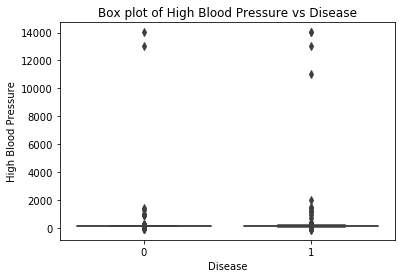

In [14]:
# Boxplot of High Blood Pressure attribute vs target attribute Disease
sns.boxplot(y="High Blood Pressure", x="Disease", data=df)
plt.title("Box plot of High Blood Pressure vs Disease")

# printing max and min High BP
print('Maximum High BP:', max(df['High Blood Pressure']))
print('Minimum High BP:', min(df['High Blood Pressure']))

In [15]:
# clipping values for High BP for train data
df['High Blood Pressure'] = df["High Blood Pressure"].clip(lower=60)
df['High Blood Pressure'] = df["High Blood Pressure"].clip(upper=250)

# clipping values for High BP for test data
test_df['High Blood Pressure'] = test_df['High Blood Pressure'].clip(lower=60)
test_df['High Blood Pressure'] = test_df['High Blood Pressure'].clip(upper=250)

#### Low Blood Pressure

- We can see from the below boxplot that the 'Low Blood Pressure' feature contains outliers
- We have clipped the lower and upper limit of this variable according to the values that are generally considered as normal Low BP in medical domain (40/160)

Maximum Low BP: 11000
Minimum Low BP: 0


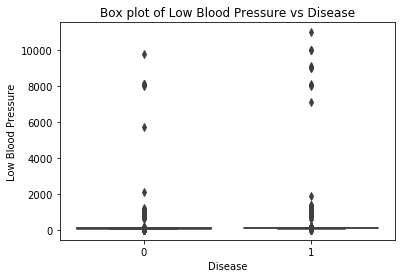

In [16]:
# Boxplot of Low Blood Pressure attribute vs target attribute Disease
sns.boxplot(y="Low Blood Pressure", x="Disease", data=df)
plt.title("Box plot of Low Blood Pressure vs Disease")

# printing max and min Low BP
print('Maximum Low BP:', max(df['Low Blood Pressure']))
print('Minimum Low BP:', min(df['Low Blood Pressure']))

In [17]:
# clipping values for Low BP for train data
df['Low Blood Pressure'] = df["Low Blood Pressure"].clip(lower=40)
df['Low Blood Pressure'] = df["Low Blood Pressure"].clip(upper=160)

# clipping values for Low BP for test data
test_df['Low Blood Pressure'] = test_df['Low Blood Pressure'].clip(lower=40)
test_df['Low Blood Pressure'] = test_df['Low Blood Pressure'].clip(upper=160)

### 3) Feature Engineering

- Feature engineering is an important step in the machine learning domain as it can help us generate new features based on some existing features in the dataset

- Here, we have calculated the Body Mass Index using the Weight and Height features and added this new feature to our dataset

- BMI is a person's weight in kilograms divided by the square of height in meters. BMI can be a good indicator of a person's health

-  A BMI higher than 30 indicates that the person is obese and a BMI of lower than 18.5 indicates that the person is underweight

- We think BMI will be an important feature that will help us in predicting disease

In [18]:
# adding BMI feature to the train data
df["BMI"]=df["Weight"]/((df['Height']/100)**2)

# adding BMI feature to the test data
test_df["BMI"]=test_df["Weight"]/((test_df['Height']/100)**2)

# printing max and min BMI in the dataset
print('Maximum BMI:', max(df['BMI']))
print('Minimum BMI:', min(df['BMI']))

Maximum BMI: 168.0
Minimum BMI: 9.46850145183689


### Exploratory Data Analysis

- Here, we have performed some exploratory data analysis on various features - 'Age', 'Gender', 'Cholestrol', 'Glucose' & 'Exercise'

- This will help us in understanding the distribution of these features in the dataset as well as their relationship with the target attribute - 'Disease'

#### Below is a Kernel density estimation plot for the 'Age' attribute which shows the distribution of 'Age' against the target feature 'Disease'. From the below plot, we can see that an old age patient is at a higher risk of having the disease. 

Minimum Age: 29
Maximum Age: 64


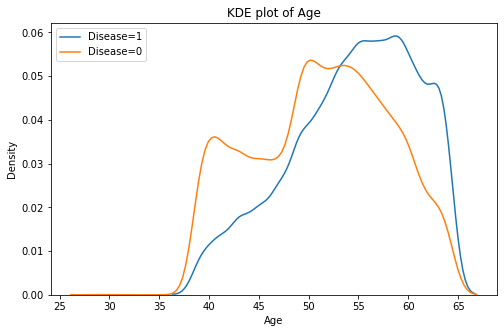

In [19]:
# KDE plot of Age Vs Disease
fig,ax=plt.subplots(1,figsize=(8,5))
ax.set_title("KDE plot of Age")
ax.set_ylabel("Density")
sns.distplot(df.Age[df.Disease==1],hist=False,label="Disease=1",ax=ax)
sns.distplot(df.Age[df.Disease==0],hist=False,label="Disease=0",ax=ax);

# printing max and min Age
print('Minimum Age:', min(df['Age']))
print('Maximum Age:', max(df['Age']))

#### Below is a distribution plot of Gender vs Disease for our dataset. We can infer from the below plot that our dataset contains more datapoints for gender=female. We can also infer that according to our dataset, males are at a slightly higher risk of having the disease than females

Text(0.5, 1.0, 'Distribution of Gender vs Disease for our dataset')

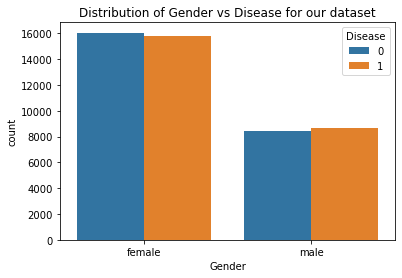

In [20]:
# Distribution plot of Gender vs Disease
sns.countplot(x="Gender", hue="Disease", data=df).set_title('Distribution of Gender vs Disease for our dataset')

#### Below is a distribution plot of Cholestrol vs Disease for our dataset. We can infer from the below plot that our dataset contains more datapoints for cholestrol=normal. We can also infer that according to our dataset, person with a very high cholestrol level is at a higher risk of having the disease

Text(0.5, 1.0, 'Distribution of Cholestrol vs Disease for our dataset')

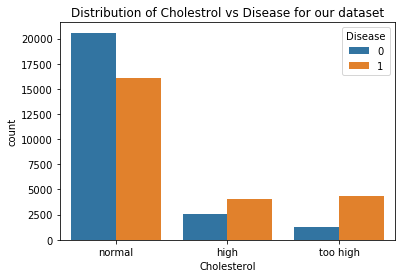

In [21]:
# Distribution plot of Cholestrol vs Disease
sns.countplot(x="Cholesterol", hue="Disease", data=df).set_title('Distribution of Cholestrol vs Disease for our dataset')

#### Below is a distribution plot of Glucose vs Disease for our dataset. We can infer from the below plot that our dataset contains more datapoints for glucose=normal. We can also infer that according to our dataset, person with a very high glucose level is at a higher risk of having the disease

Text(0.5, 1.0, 'Distribution of Glucose vs Disease for our dataset')

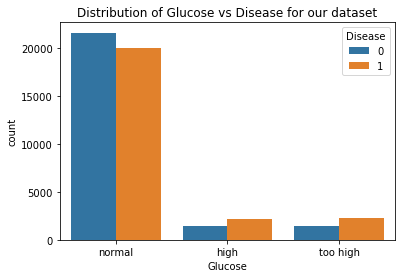

In [22]:
# Distribution plot of Glucose vs Disease
sns.countplot(x="Glucose", hue="Disease", data=df).set_title('Distribution of Glucose vs Disease for our dataset')

#### Below is a distribution plot of Exercise vs Disease for our dataset. We can infer from the plot below that according to our dataset, person who does regular exercise is at a lower risk of having the disease

Text(0.5, 1.0, 'Distribution of Exercise vs Disease for our dataset')

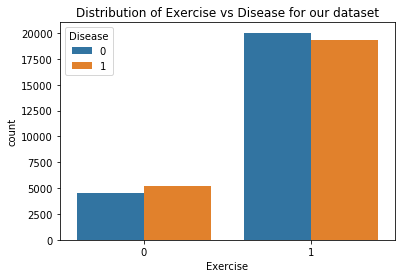

In [23]:
# Distribution plot of Exercise vs Disease
sns.countplot(x="Exercise", hue="Disease", data=df).set_title('Distribution of Exercise vs Disease for our dataset')

### 4) Data Transformations

- Here, we have performed several data transformations that will help our machine learning models in predicting the correct labels for Disease

- We have performed Binning on the Age feature and converted this attribute into 8 bins. We have seen previously from the KDE plot for Age vs Disease that the possibility of having the disease increases with age. So, we believe binning the Age feature into categories will help us in predicting the disease

-  We have also performed One-hot encoding for all the categorical features present in our dataset. After performing the One-hot encoding, we have removed one column for each of the categorical attribute. We only need to keep n-1 columns after performing One-hot encoding to remove the redundancy in our dataset.

### Binning

#### Adding a new feature 'Age_Binning' to both the train and test data

In [24]:
# creating labels for the new binned feature
ages = ['Age 25-29','Age 30-34','Age 35-39','Age 40-44','Age 45-49','Age 50-54','Age 55-59','Age 60-64']

# adding a new feature 'Age_Binning' by performing binning on 'Age' attribute for both train and test dataset
df['Age_Binning'] = pd.cut(df['Age'], bins=np.linspace(25, 65, 9), labels=ages)
test_df['Age_Binning'] = pd.cut(test_df['Age'], bins=np.linspace(25, 65, 9), labels=ages)

#### Distribution of binned age attribute against the target feature - 'Disease'. We can infer from the below plot that people in the higher age categories i.e. 50-54, 55-59, 60-64 are at the highest risk of having the disease

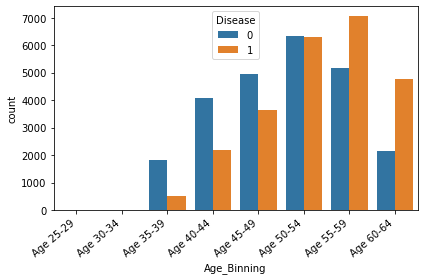

In [25]:
# plot of 'Age_Binning' vs 'Disease'
ax = sns.countplot(x="Age_Binning", hue = 'Disease', data=df)

# rotating the labels on the x-axis
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

### One-hot encoding

- Here, we can converted all the categorical features present in our train and test dataset into numerical features using One-hot encoding

- We have only kept n-1 columns after performing One-hot encoding as this will help in reducing the redundancy in our dataset

In [26]:
# One-hot encoding on train data
df=pd.get_dummies(df)

# One-hot encoding on test data
test_df=pd.get_dummies(test_df)

In [27]:
# Dropping 1 column each and keeping n-1 columns for all the One-hot encoded attributes on both train and test data
df.drop(["Age",'Cholesterol_too high','Glucose_too high','Age_Binning_Age 60-64'],inplace=True,axis=1)
test_df.drop(["Age",'Cholesterol_too high','Glucose_too high','Age_Binning_Age 60-64'],inplace=True,axis=1)

In [28]:
# Dropping 1 column each and keeping n-1 columns for all the One-hot encoded attributes on both train and test data
df.drop(['Gender_female'],inplace=True,axis=1)
test_df.drop(['Gender_female'],inplace=True,axis=1)

## Model Building

-  Here, we have performed some pre-processing steps required for all of our machine learning models

- Firstly, we have performed a train-validation split on our training dataset using 70-30 as the size. This will help prevent our models from overfitting and we will also be able to perform hyper-parameter tuning on validation set

- Secondly, we have used the StandardScalar technique to scale our dataset. This is an important technique which can help us improve the perfomance of our models. We have scaled the train data, validation data and the test data as well. Scaling the dataset in an important step for models that use distance-based techniques for prediction

- Thirdly, we have created a generic AUC-ROC function which will help us generate the Area Under the Receiver Operating Characrteristic curve for all the models that can predict the probability of the target class labels

- Finally, we have removed the 'ID' column from the test dataset as it will not be helpful in performing the predictions on the test data. We have popped the 'ID' column from test data and inserted it into a new dataframe - 'final_prediction' which we will be using later on to store the final predictions on test data

## Evaluation metric - Recall
- We have used the evaluation metric as Recall for all the machine learning models that we have implemented
- Though, we could have also used Accuracy as the evaluation metric because our training dataset is balanced i.e. it contains the same amount of data points for both the target labels 0 and 1
- But we have selected the metric as Recall because our goal here is to predict whether a patient has a disease or not
- So, for our kind of classification problem, it is extremely important for our models to reduce the number of 'false-negatives'. We do not want our models to predict a patient as 'not having the disease' when that patient actually 'has the disease'

In [29]:
# Define X & y for the split
X = df.drop('Disease', axis=1)
y = df['Disease']

In [30]:
# 70-30 train-validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

In [31]:
# Initializing standard scalar
scaler=StandardScaler()

In [32]:
# Scaling train data
X_train[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure','BMI']]=scaler.fit_transform(X_train[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure','BMI']])

/Users/sankalpsingh/Vicky/Softwares/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sankalpsingh/Vicky/Softwares/Anaconda/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [33]:
# Scaling validation data
X_test[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure','BMI']]=scaler.transform(X_test[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure','BMI']])

/Users/sankalpsingh/Vicky/Softwares/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sankalpsingh/Vicky/Softwares/Anaconda/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [34]:
# Scaling test data
test_df[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure','BMI']]=scaler.transform(test_df[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure','BMI']])

In [35]:
# creating a new dataframe for storing the test data predictions
final_prediction=pd.DataFrame()

In [36]:
# Popping 'ID' column from test dataframe to prediction dataframe
final_prediction["ID"]=test_df.pop("ID")

#### ROC function - generic AUC-ROC function which will help us generate the Area Under the Receiver Operating Characteristic curve for all the models that can predict the probability of the target class labels

In [37]:
# Function to plot ROC_AUC_curve

def ROC_AUC_curve(model,model_name="Model"):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.figure(figsize=(8,4))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

#### ROC function - generic AUC-ROC upgraded function which will help us generate the Area Under the Receiver Operating Characteristic curve for ANN models that can predict the probability of the target class labels

In [38]:
# Function to plot ROC_AUC_curve

def ROC_AUC_curve_upgraded(model,model_name="Model"):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Decision Tree: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.figure(figsize=(8,4))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

## Logistic Regression

- We have implemented the Logistic Regression classifier model here
- We have used a 5 folds cross validation grid search to perform the hyper-parameter tuning in order to achieve the best recall for our model
- We have used recall as scoring for the grid search
- After this, we have printed the classification report for our model on training data, validation data in order to get a sense of how well our model is performing in terms of precision, recall, f1-score and accuracy and to see if our model is overfitting on the training data
- We have predicted the target class labels for our testing dataset by using the best fitted model
- We have also generated an AUC-ROC curve for the Logistic Regression model

In [39]:
# initializing the LR model
lr=LogisticRegression(random_state=16,solver="liblinear")

#### Hyper-paramater tuning using GridSearch:

- C: This is the cost parameter. It is the inverse of the lambda. Smaller value specify more regularization

- Penalty: The types of penalty that can be used are l1 and l2. The l1 penalty has the characteristics of eliminating features by making its co-efficient 0. The l2 penalty does not eliminate features but it penalizes the effect of less useful features and makes their co-efficient close to 0


In [40]:
# Performing grid search to find the best hyper-parameters
param_grid_lr = {
              'C': [.001,.005,.01,0.1,0.3,0.5,1,3,5,10],
              'penalty': ['l1', 'l2']
              }

In [41]:
# Using 5 fold cross validation and evaluation metric as Recall
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='recall', n_jobs=-1, verbose=1)

In [42]:
# Fitting LR model
lr_model = grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.9s finished


In [43]:
# printing best hyper-parameters for model
lr_best_params = grid_lr.best_params_
print(lr_best_params)

{'C': 5, 'penalty': 'l1'}


In [44]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(lr_model.predict(X_train),y_train))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74     18968
           1       0.68      0.76      0.71     15332

    accuracy                           0.73     34300
   macro avg       0.73      0.73      0.73     34300
weighted avg       0.74      0.73      0.73     34300



In [45]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(lr_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.79      0.71      0.74      8139
           1       0.68      0.76      0.72      6561

    accuracy                           0.73     14700
   macro avg       0.73      0.73      0.73     14700
weighted avg       0.74      0.73      0.73     14700



In [46]:
# Predicting disease labels for test dataset
test_prediction_lr = lr_model.predict(test_df)

#### Generating the AUC-ROC curve for the LR model
- The AUC-ROC score that we get from the graph that we have plotted below tells us that our model is able to distinguish between the patients, if they have a disease or not, 79.4% of the time.
- The score is above 50% which means that the model is not just randomly predicting the probability of a patient having the disease

No Skill: ROC AUC=0.500
Model: ROC AUC=0.794


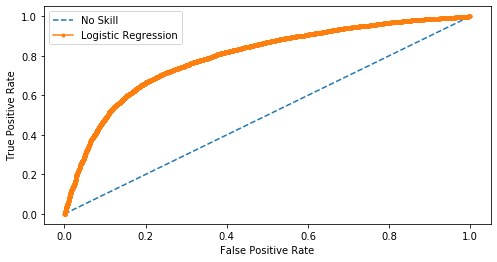

In [47]:
# printing the AUC-ROC for LR model
ROC_AUC_curve(model=lr_model,model_name="Logistic Regression")

#### Coefficients for Logistic Regression Model
- As we have used the l1 regularization paramater, we can see that the coefficient for the feature 'Age_Binning_Age 30-34' has been reduced to zero as part of the l1 penalty
- We can also conclude that High Blood Pressure has the highest coefficient indicating that high BP increases the odds of having the disease the most
- Similarly, we can conclude that 'Age_Binning_Age 25-29' - increases the odds of having the disease the least

In [48]:
# printing the coefficients of LR model
lr_coefficients=OrderedDict(sorted(zip(X_train.columns,grid_lr.best_estimator_.coef_[0]),reverse=True,key=lambda x:x[1]))

In [49]:
# printing the coefficients 
pd.Series(lr_coefficients)

High Blood Pressure      0.884664
Glucose_high             0.295397
Glucose_normal           0.274231
Low Blood Pressure       0.196945
Weight                   0.162313
Age_Binning_Age 30-34    0.000000
Gender_male             -0.005602
BMI                     -0.010491
Height                  -0.045463
Alcohol                 -0.129690
Smoke                   -0.131314
Exercise                -0.232351
Age_Binning_Age 55-59   -0.388198
Age_Binning_Age 50-54   -0.598488
Cholesterol_high        -0.641938
Age_Binning_Age 45-49   -0.783604
Age_Binning_Age 40-44   -1.012088
Cholesterol_normal      -1.056953
Age_Binning_Age 35-39   -1.557555
Age_Binning_Age 25-29   -2.096229
dtype: float64

## Decision Tree
- We have implemented the Decision Trees classifier model here
- We have used a grid search to perform the hyper parameter tuning in order to achieve the best recall for our model
- We have used recall as scoring for the grid search
- After this, we have printed the classification report for our model on training data, validation data in order to get a sense of how well our model is performing in terms of precision, recall, f1-score and accuracy
- We have predicted the target class labels for our testing dataset by using the best fitted model
- We have also generated an AUC-ROC curve for the DT model

In [50]:
# initializing the DT model
dt=DecisionTreeClassifier(random_state=42)

#### Hyper-paramater tuning using GridSearch:
- criterion: The criterion that will be used to split a node. This can be either gini index or entropy
- max_features: The max_features is the number of features that will be used for making a single tree. For eg using "sqrt", the tree uses the square root of the number of total features in the data. Using auto is the same as making use of sqrt. The other values can be specifying the int(number of features to be used), log, and proportion of the features to be used
- min_samples_split: The number of samples that should be present in the node for it to be split further
- max_depth: The maxdepth represents the depth of the tree. The deeper the tree, the more splits it has and it captures more information about the data. In order to avoid overfitting the data, we use the maxDepth to specify the depth till which the tree can split
- min_samples_leaf: This helps in pruning the decision tree. It ensures that the leaf contain atleast the mentioned number of samples
- max_leaf_nodes: Total number of terminal nodes in a tree

In [51]:
# Using grid search for hyper-parameter tuning
param_grid_dt = { 'criterion':['gini','entropy'],
                 'max_features': ['auto','log2'],
              'min_samples_split':[25,50,100,200],
              'max_depth': [5,10,20,25,30],
              'min_samples_leaf': [1,3,5,10,20],
              'max_leaf_nodes': [2,5,10,20,40]}

In [52]:
# Using grid search and evaluation metric as Recall
grid_dt = GridSearchCV(dt, param_grid_dt, scoring='recall', n_jobs=-1, verbose=1)

In [53]:
# Fitting dt model
dt_model = grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 4928 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7128 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 9728 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  2.1min finished


In [54]:
# printing the best hyper-parameters
dt_best_params = grid_dt.best_params_
print(dt_best_params)

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': 40, 'min_samples_leaf': 20, 'min_samples_split': 200}


In [55]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(dt_model.predict(X_train),y_train))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73     20377
           1       0.61      0.75      0.67     13923

    accuracy                           0.71     34300
   macro avg       0.71      0.71      0.70     34300
weighted avg       0.72      0.71      0.71     34300



In [56]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(dt_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.80      0.66      0.72      8743
           1       0.60      0.75      0.67      5957

    accuracy                           0.70     14700
   macro avg       0.70      0.71      0.70     14700
weighted avg       0.72      0.70      0.70     14700



In [57]:
# Predicting disease labels for test dataset
test_prediction_dt = dt_model.predict(test_df)

#### Saving the model using pickle library

In [58]:
# Save the trained model as a pickle string. 
saved_dt_model = pickle.dumps(dt_model) 
  
# Load the pickled model 
dt_from_pickle = pickle.loads(saved_dt_model) 

#### Generating the AUC-ROC curve for the DT model
- The AUC-ROC score that we get from the graph that we have plotted below tells us that our model is able to distinguish between the patients, if they have a disease or not, 75.2% of the time.
- The score is above 50% which means that the model is not just randomly predicting the probability of a patient having the disease

No Skill: ROC AUC=0.500
Model: ROC AUC=0.752


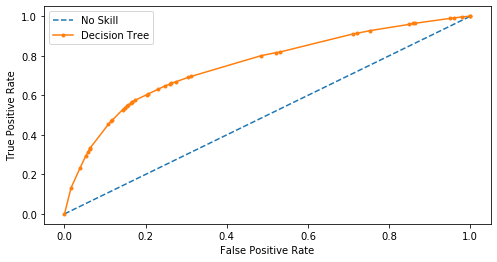

In [59]:
# ROC curve for DT model
ROC_AUC_curve(model=dt_model,model_name="Decision Tree")

#### Feature Importance Plot for Decision Tree Classifier

In [60]:
# creating a new dataframe to store the features and their respective importance values
feature_imp = pd.DataFrame(dt_model.best_estimator_.feature_importances_, index=X_train.columns,
columns=['importance']).sort_values('importance', ascending=False)
feature_imp['features'] = feature_imp.index
feature_imp

,importance,features
Low Blood Pressure,0.323554,Low Blood Pressure
High Blood Pressure,0.319757,High Blood Pressure
Cholesterol_normal,0.145995,Cholesterol_normal
Weight,0.117949,Weight
Age_Binning_Age 40-44,0.035675,Age_Binning_Age 40-44
Age_Binning_Age 35-39,0.020127,Age_Binning_Age 35-39
BMI,0.019912,BMI
Age_Binning_Age 55-59,0.011301,Age_Binning_Age 55-59
Cholesterol_high,0.001900,Cholesterol_high
Glucose_normal,0.001427,Glucose_normal


#### Below feature importance plot shows that the top 5 features that are most helpful in predicting the disease for our dataset are:
1) Low Blood Pressure

2) High Blood Pressure 

3) Cholestrol_normal

4) Weight

5) Age_Binning_Age_40-44

- We can see that the Body Mass Index feature that we added in our dataset as part of the feature engineering is also one of the important features helpful in predicting the 'disease' target attribute

Text(0, 0.5, 'FEATURE NAMES')

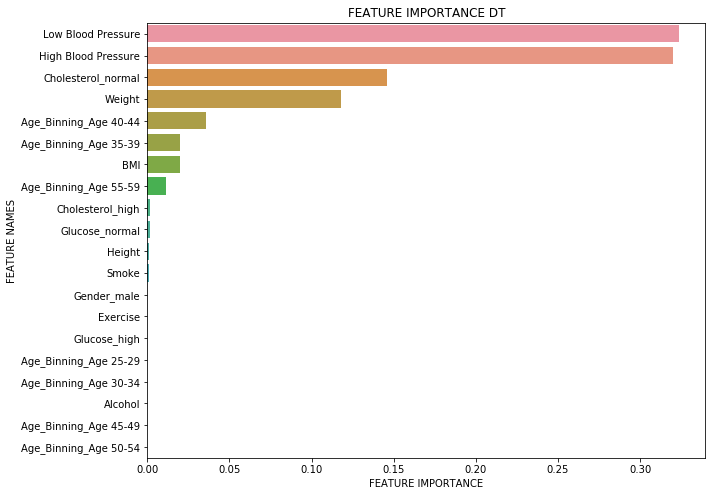

In [61]:
# Plotting Feature Importance graph
plt.figure(figsize=(10,8))

sns.barplot(x=feature_imp['importance'], y=feature_imp['features'])

plt.title('FEATURE IMPORTANCE DT')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

## ANN0 - 0 Hidden Layers
- We have implemented the Artificial Neural Network model with 0 hidden layers here
- The ANN0 model contains an initial sequential layer followed by dense output layer that uses 'sigmoid' as the activation function in order to predict the binary labels for output class.
- The input shape is the total number of features present in the training data i.e. 20
- We have used the loss function as 'binary_crossentropy', optimizer as 'adam' and metrics as 'accuracy' to implement a deep learning network with no hidden layers
- We have used epochs and batch_size for the hyperparameter tuning of the model and have calculated the loss and accuracy for both train and validation data for each epoch
- After this, we have printed the classification report for our model on training data, validation data in order to get a sense of how well our model is performing in terms of precision, recall, f1-score and accuracy
- We have predicted the target class labels for our testing dataset by using the best fitted model
- We have generated an AUC-ROC curve as ANN0 model that predicts the probability of the target class labels

In [62]:
# initializing the ANN0 model
ann0 = Sequential()
ann0.add(Dense(1, activation='sigmoid', input_shape=(20,)))

#### Hyper-paramater tuning using GridSearch:
- activation: 'sigmoid' function is used in the output layer as this is a binary classification problem
- loss: We have used the loss function here as the 'binary_crossentropy' which is a popular loss function for Neural Networks when we are trying to predict a binary output class
- optimizer: 'adam' optimizer has been used here. Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments
- epochs: This parameter indicates the number of passes of the entire training dataset the neural network model has completed. We have used here 50 epochs to train our model
- batch_size: The batch size is fed to the model for a single update to the weights. The batch_size can be any of the below three:
                - Batch Gradient Descent. Batch Size = Size of Training Set
                - Stochastic Gradient Descent. Batch Size = 1
                - Mini-Batch Gradient Descent. 1 < Batch Size < Size of Training Set
- Here we have used the mini batch size as 20

In [63]:
# Compiling the ANN0 model
ann0.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [64]:
# Fitting the ANN0 model
ann0.fit(X_train, y_train, epochs=50, batch_size=20, verbose=1,validation_data=(X_test,y_test))

Train on 34300 samples, validate on 14700 samples
Epoch 1/50
34300/34300 [==============================] - 4s 123us/step - loss: 0.6029 - accuracy: 0.6890 - val_loss: 0.5876 - val_accuracy: 0.7031
Epoch 2/50
34300/34300 [==============================] - 4s 107us/step - loss: 0.5831 - accuracy: 0.7096 - val_loss: 0.5803 - val_accuracy: 0.7102
Epoch 3/50
34300/34300 [==============================] - 4s 107us/step - loss: 0.5781 - accuracy: 0.7146 - val_loss: 0.5766 - val_accuracy: 0.7131
Epoch 4/50
34300/34300 [==============================] - 4s 106us/step - loss: 0.5754 - accuracy: 0.7157 - val_loss: 0.5741 - val_accuracy: 0.7139
Epoch 5/50
34300/34300 [==============================] - 4s 106us/step - loss: 0.5735 - accuracy: 0.7185 - val_loss: 0.5724 - val_accuracy: 0.7165
Epoch 6/50
34300/34300 [==============================] - 4s 105us/step - loss: 0.5722 - accuracy: 0.7201 - val_loss: 0.5712 - val_accuracy: 0.7163
Epoch 7/50
34300/34300 [==============================] - 4s 1

In [65]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(y_true=y_train,y_pred=(ann0.predict(X_train)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.70      0.79      0.75     17204
           1       0.76      0.66      0.71     17096

    accuracy                           0.73     34300
   macro avg       0.73      0.73      0.73     34300
weighted avg       0.73      0.73      0.73     34300



In [66]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(y_true=y_test,y_pred=(ann0.predict(X_test)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.70      0.80      0.75      7298
           1       0.77      0.66      0.71      7402

    accuracy                           0.73     14700
   macro avg       0.74      0.73      0.73     14700
weighted avg       0.74      0.73      0.73     14700



In [67]:
# Predicting disease labels for test dataset
test_prediction_ann0=(ann0.predict_proba(test_df)>0.5).astype(int)

#### Generating the AUC-ROC curve for the ANN0 model
- The AUC-ROC score that we get from the graph that we have plotted below tells us that our model is able to distinguish between the patients, if they have a disease or not, 79.3% of the time.
- The score is above 50% which means that the model is not just randomly predicting the probability of a patient having the disease

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.793


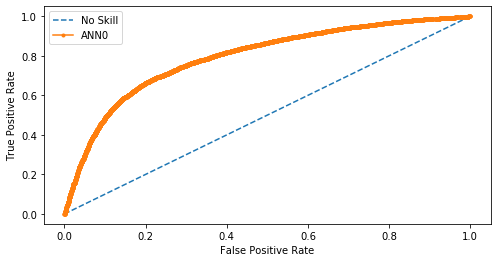

In [68]:
# generating ROC curve for ANN0
ROC_AUC_curve_upgraded(model=ann0,model_name="ANN0")

## ANN1 - 1 Hidden Layers
- We have implemented the Artificial Neural Network model with 1 hidden layers here
- The ANN1 model contains an initial sequential layer followed by the dense hidden layer using activation function as 'relu' and 40 nodes followed by dense output layer that uses 'sigmoid' as the activation function in order to predict the binary labels for output class.
- The input shape is the total number of features present in the training data i.e. 20
- The hidden layer contains 40 nodes of perceptrons
- We have used the loss function as 'binary_crossentropy', optimizer as 'adam' and metrics as 'accuracy' to implement a deep learning network with 1 hidden layers
- We have used epochs and batch_size for the hyperparameter tuning of the model and have calculated the loss and accuracy for both train and validation data for each epoch
- After this, we have printed the classification report for our model on training data, validation data in order to get a sense of how well our model is performing in terms of precision, recall, f1-score and accuracy
- We have predicted the target class labels for our testing dataset by using the best fitted model
- We have generated an AUC-ROC curve as ANN1 model that predicts the probability of the target class labels

In [69]:
# initializing the ANN1 model
ann1 = Sequential()
ann1.add(Dense(40, activation='relu', input_shape=(20,)))
ann1.add(Dense(1, activation='sigmoid', input_shape=(40,)))

#### Hyper-paramater tuning using GridSearch:
- activation: 'relu' or rectified linear activation function is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. 'Relu' has been used for the hidden layer activation and 'sigmoid' function is used in the output layer as this is a binary classification problem
- loss: We have used the loss function here as the 'binary_crossentropy' which is a popular loss function for Neural Networks when we are trying to predict a binary output class
- optimizer: 'adam' optimizer has been used here. Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments
- epochs: This parameter indicates the number of passes of the entire training dataset the neural network model has completed. We have used here 50 epochs to train our model
- batch_size: The batch size is fed to the model for a single update to the weights. The batch_size can be any of the below three:
                - Batch Gradient Descent. Batch Size = Size of Training Set
                - Stochastic Gradient Descent. Batch Size = 1
                - Mini-Batch Gradient Descent. 1 < Batch Size < Size of Training Set
- Here we have used the mini batch size as 20

In [70]:
# compiling ANN1 model
ann1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [71]:
# fitting ANN1 model
ann1.fit(X_train, y_train, epochs=50, batch_size=20, verbose=1,validation_data=(X_test,y_test))

Train on 34300 samples, validate on 14700 samples
Epoch 1/50
34300/34300 [==============================] - 5s 145us/step - loss: 0.5721 - accuracy: 0.7139 - val_loss: 0.5626 - val_accuracy: 0.7209
Epoch 2/50
34300/34300 [==============================] - 4s 124us/step - loss: 0.5569 - accuracy: 0.7253 - val_loss: 0.5555 - val_accuracy: 0.7264
Epoch 3/50
34300/34300 [==============================] - 5s 153us/step - loss: 0.5517 - accuracy: 0.7288 - val_loss: 0.5512 - val_accuracy: 0.7291
Epoch 4/50
34300/34300 [==============================] - 5s 147us/step - loss: 0.5477 - accuracy: 0.7315 - val_loss: 0.5485 - val_accuracy: 0.7316
Epoch 5/50
34300/34300 [==============================] - 4s 130us/step - loss: 0.5449 - accuracy: 0.7331 - val_loss: 0.5461 - val_accuracy: 0.7328
Epoch 6/50
34300/34300 [==============================] - 4s 123us/step - loss: 0.5429 - accuracy: 0.7361 - val_loss: 0.5446 - val_accuracy: 0.7328
Epoch 7/50
34300/34300 [==============================] - 4s 1

In [72]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(y_true=y_train,y_pred=(ann1.predict(X_train)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75     17204
           1       0.76      0.70      0.73     17096

    accuracy                           0.74     34300
   macro avg       0.74      0.74      0.74     34300
weighted avg       0.74      0.74      0.74     34300



In [73]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(y_true=y_test,y_pred=(ann1.predict(X_test)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.71      0.78      0.75      7298
           1       0.76      0.69      0.72      7402

    accuracy                           0.73     14700
   macro avg       0.74      0.73      0.73     14700
weighted avg       0.74      0.73      0.73     14700



In [74]:
# Predicting disease labels for test dataset
test_prediction_ann1=(ann1.predict_proba(test_df)>0.5).astype(int)

#### Generating the AUC-ROC curve for the ANN1 model
- The AUC-ROC score that we get from the graph that we have plotted below tells us that our model is able to distinguish between the patients, if they have a disease or not, 80.2% of the time.
- The score is above 50% which means that the model is not just randomly predicting the probability of a patient having the disease

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.802


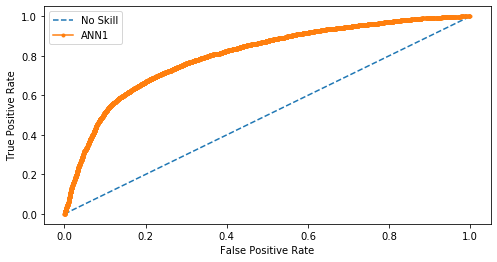

In [75]:
# generating ROC curve for ANN1 model
ROC_AUC_curve_upgraded(model=ann1,model_name="ANN1")

## ANN2 - 2 Hidden Layers
- We have implemented the Artificial Neural Network model with 12 hidden layers here
- The ANN2 model contains an initial sequential layer followed by the dense hidden layer using activation function as 'relu' and 40 nodes followed by another hidden layer with 10 nodes and 'relu' activation and finally a dense output layer that uses 'sigmoid' as the activation function in order to predict the binary labels for output class.
- The input shape is the total number of features present in the training data i.e. 20
- The 1st hidden layer contains 40 nodes of perceptrons
- The 2nd hidden layer contains 10 nodes
- We have used the loss function as 'binary_crossentropy', optimizer as 'adam' and metrics as 'accuracy' to implement a deep learning network with 2 hidden layers
- We have used epochs and batch_size for the hyperparameter tuning of the model and have calculated the loss and accuracy for both train and validation data for each epoch
- After this, we have printed the classification report for our model on training data, validation data in order to get a sense of how well our model is performing in terms of precision, recall, f1-score and accuracy
- We have predicted the target class labels for our testing dataset by using the best fitted model
- We have generated an AUC-ROC curve as ANN2 model that predicts the probability of the target class labels

In [76]:
# initializing the ANN2 model
ann2 = Sequential()
ann2.add(Dense(40, activation='relu', input_shape=(20,)))
ann2.add(Dense(10, activation='relu', input_shape=(40,)))
ann2.add(Dense(1, activation='sigmoid', input_shape=(10,)))

#### Hyper-paramater tuning using GridSearch:
- activation: 'relu' or rectified linear activation function is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. 'Relu' has been used for the first two hidden layers as the activation function and 'sigmoid' function is used in the output layer as this is a binary classification problem
- loss: We have used the loss function here as the 'binary_crossentropy' which is a popular loss function for Neural Networks when we are trying to predict a binary output class
- optimizer: 'adam' optimizer has been used here. Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments
- epochs: This parameter indicates the number of passes of the entire training dataset the neural network model has completed. We have used here 50 epochs to train our model
- batch_size: The batch size is fed to the model for a single update to the weights. The batch_size can be any of the below three:
                - Batch Gradient Descent. Batch Size = Size of Training Set
                - Stochastic Gradient Descent. Batch Size = 1
                - Mini-Batch Gradient Descent. 1 < Batch Size < Size of Training Set
- Here we have used the mini batch size as 20

In [77]:
# compiling the ANN2 model
ann2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [78]:
# fitting the ANN2 model
ann2.fit(X_train, y_train, epochs=50, batch_size=20, verbose=1,validation_data=(X_test,y_test))

Train on 34300 samples, validate on 14700 samples
Epoch 1/50
34300/34300 [==============================] - 6s 180us/step - loss: 0.5671 - accuracy: 0.7151 - val_loss: 0.5562 - val_accuracy: 0.7203
Epoch 2/50
34300/34300 [==============================] - 7s 199us/step - loss: 0.5508 - accuracy: 0.7275 - val_loss: 0.5504 - val_accuracy: 0.7257
Epoch 3/50
34300/34300 [==============================] - 6s 165us/step - loss: 0.5460 - accuracy: 0.7301 - val_loss: 0.5478 - val_accuracy: 0.7286
Epoch 4/50
34300/34300 [==============================] - 5s 160us/step - loss: 0.5430 - accuracy: 0.7331 - val_loss: 0.5461 - val_accuracy: 0.7289
Epoch 5/50
34300/34300 [==============================] - 6s 166us/step - loss: 0.5408 - accuracy: 0.7354 - val_loss: 0.5449 - val_accuracy: 0.7301
Epoch 6/50
34300/34300 [==============================] - 5s 135us/step - loss: 0.5394 - accuracy: 0.7348 - val_loss: 0.5437 - val_accuracy: 0.7318
Epoch 7/50
34300/34300 [==============================] - 5s 1

In [79]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(y_true=y_train,y_pred=(ann2.predict(X_train)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76     17204
           1       0.77      0.70      0.73     17096

    accuracy                           0.74     34300
   macro avg       0.75      0.74      0.74     34300
weighted avg       0.75      0.74      0.74     34300



In [80]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(y_true=y_test,y_pred=(ann2.predict(X_test)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      7298
           1       0.76      0.68      0.72      7402

    accuracy                           0.73     14700
   macro avg       0.73      0.73      0.73     14700
weighted avg       0.73      0.73      0.73     14700



In [81]:
# Predicting disease labels for test dataset
test_prediction_ann2=(ann2.predict_proba(test_df)>0.5).astype(int)

#### Generating the AUC-ROC curve for the ANN2 model
- The AUC-ROC score that we get from the graph that we have plotted below tells us that our model is able to distinguish between the patients, if they have a disease or not, 80% of the time.
- The score is above 50% which means that the model is not just randomly predicting the probability of a patient having the disease

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.800


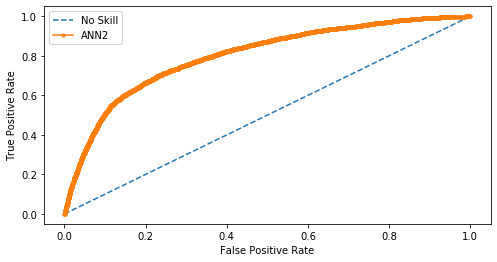

In [82]:
ROC_AUC_curve_upgraded(model=ann2,model_name="ANN2")

## Conclusion: Prediction and Interpretation
- Below, we have summarized the results for all the 11 machine learning models that we have implemented for the Disease prediction problem in HW4 and HW3 altogether

- The below table contains names of all the algorithms that we have implemented, their evaluation metric - Recall scores along with AUC,Accuracy, Time taken to run the model and the best hyper-parameters for each of the model obtained through the Grid Search

- From the summary table we can conclude: Logistic Regression, Linear SVM and ANN0 can be seen to be very close to each other in terms of similar validation accuracy. The results are close due to the fact that all of them use a linear boundary to separate the classes

- For ANN models, increasing the number of hidden layers initially led to an increase in Recall but then after sometime led to a decrease in Recall

- For ANN models, increasing the number of hidden layers also led to an increase in the training accuracy but the validation accuracy did not increase after one point. This was a sign of overfitting on the training dataset

- Logistic Regression and Decision Tree models have a higher Recall as compared to most of the other models. Logistic Regression and Linear SVM have performed extremely well indicating that a linear decision boundary is really helpful and can be used to separate the binary output classes

- We can infer from the below table that SVM-Linear model is by far the best model to predict the disease target labels. SVM model has the highest recall score (79%). This means that a linear decision boundary could be really helpful for our dataset as we are trying to predict whether a patient has the disease or not by separting target attribute into two classes 0/1

- We can also infer that the ANN1 model has the highest Area Under the Receiver Operating Characteristic curve (80.2%) and the highest Accuracy as well (73%). This means that ANN1 model is also performing very well and is able to distinguish if a person has a disease or not almost 80% of the times

- We have used the evaluation metric as Recall for predicting the disease target label. We have selected Recall as the evaluation metric because it is very important for our models to correctly predict the patients with disease when they actually have the disease. We need to lower the number of 'false-negatives' in our predictions

- We can also see that all of our models have a close training and test accuracy scores. This means that our models are not prone to overfitting and they have generalized quite well on the data. One of the reasons behind this could be that training and testing datasets have a similar distribution.

- Below, we have also created a summary table indicating the top 5 most important features helpful in predicting disease according to the DT, RF and GBM models and the top 5 coefficients from the LR model. Results indicate that High Blood Pressure is one of the most important indicators of disease

In [83]:
# Creating a summary table for the model names, their recall, auc, accuracy scores, time taken to run the model and their best hyper parameters
best_models = pd.DataFrame({"Algorithm":["NBC","KNN","SVM-Linear","SVM-RBF","RF","GBM","DT","LR","ANN0","ANN1","ANN2" ], "Recall":[71,73,79,61,76,73,75,76,66,69,68],
                            "AUC":[74.3,76.2,'-','-',79.9,78.8,75.2,79.4,79.3,80.2,80], 'Accuracy':[69,72,73,64,73,72,70,73,73,73,73],
                            'Ball-park estimate of Time taken to run model(mins)':[2,24,4,30,50,480,2.10,16.90,3.33,4.16,5],
                            "Best Hyper-parameters":["var_smoothing:0.001",
                                                     "algorithm:brute,n_neighbors:50,p:2,weights:distance",
                                                     "C:0.8,loss:hinge,penalty:l2",
                                                     "C: 0.01,gamma: 1",
                                               "max_depth:100,max_features:auto,min_samples_leaf:10,min_samples_split:100,n_estimators:100",
                                               "max_depth:50,max_features:sqrt,min_samples_leaf:10,min_samples_split:200,n_estimators:100,subsample:0.8",
                                                     "C:5, penalty:l1",
                                                     "criterion:gini,max_depth:10,max_features:auto,max_leaf_nodes:40,min_samples_leaf:20,min_samples_split:200",
                                                    "epochs:50,batch_size:20,loss_function:binary_crossentrpy,optimizer:adam",
                                                    "epochs:50,batch_size:20,loss_function:binary_crossentrpy,optimizer:adam",
                                                    "epochs:50,batch_size:20,loss_function:binary_crossentrpy,optimizer:adam"]})

In [84]:
# Printing the best_models summary table by sorting on the primary evaluation metric recall
best_models.sort_values(by="Recall",ascending=False)

,Algorithm,Recall,AUC,Accuracy,Ball-park estimate of Time taken to run model(mins),Best Hyper-parameters
2,SVM-Linear,79,-,73,4.00,"C:0.8,loss:hinge,penalty:l2"
4,RF,76,79.9,73,50.00,"max_depth:100,max_features:auto,min_samples_le..."
7,LR,76,79.4,73,11.30,"criterion:gini,max_depth:10,max_features:auto,..."
6,DT,75,75.2,70,2.60,"C:5, penalty:l1"
1,KNN,73,76.2,72,24.00,"algorithm:brute,n_neighbors:50,p:2,weights:dis..."
5,GBM,73,78.8,72,480.00,"max_depth:50,max_features:sqrt,min_samples_lea..."
0,NBC,71,74.3,69,2.00,var_smoothing:0.001
9,ANN1,69,80.2,73,4.16,"epochs:50,batch_size:20,loss_function:binary_c..."
10,ANN2,68,80,73,5.00,"epochs:50,batch_size:20,loss_function:binary_c..."
8,ANN0,66,79.3,73,3.33,"epochs:50,batch_size:20,loss_function:binary_c..."


#### Top 5 most important features helpful in predicting disease
- High Blood Pressure and Low Blood Pressure are the most important features in predicting whether a patient has disease
- Cholestrol_normal, Weight, Height, BMI, Glucose and Age_Binning_Age_40-44 are other features that are helpful in predicting disease

In [88]:
# top 5 feature importance for DT, RF, GBM
best_feature_importance=pd.DataFrame({"Random Forest":['High Blood Pressure','Low Blood Pressure','Cholesterol_normal','BMI','Weight'],
            "GBM":['High Blood Pressure','Low Blood Pressure','BMI','Weight','Height'],
            "Decision Tree":['Low Blood Pressure','High Blood Pressure','Cholesterol_normal','Weight','Age_Binning_Age_40-44'],
             "LR Coefficients":['High Blood Pressure','Glucose_high','Glucose_normal','Low Blood Pressure','Weight']})
print("Top 5 most important features in predicting disease")
best_feature_importance

Top 5 most important features in predicting disease


,Random Forest,GBM,Decision Tree,LR Coefficients
0,High Blood Pressure,High Blood Pressure,Low Blood Pressure,High Blood Pressure
1,Low Blood Pressure,Low Blood Pressure,High Blood Pressure,Glucose_high
2,Cholesterol_normal,BMI,Cholesterol_normal,Glucose_normal
3,BMI,Weight,Weight,Low Blood Pressure
4,Weight,Height,Age_Binning_Age_40-44,Weight


## Final Predictions on Test Set 

- We have made a final dataframe containing the test set predictions for all the 5 algorithms.

- We have also converted this dataframe to a csv that contains 6 columns: 

- ID: contains the ID for each of the data points present in the test set 

- DT: contains binary prediction labels made by the DT algorithm for each of the data points present in the test set 

- LR: contains binary prediction labels made by the LR algorithm for each of the data points present in the test set 

- ANN0: contains binary prediction labels made by the ANN0 algorithm for each of the data points present in the test set 

- ANN1: contains binary prediction labels made by the ANN1 algorithm for each of the data points present in the test set 

- ANN2: contains binary prediction labels made by the ANN2 for each of the data points present in the test set 

In [86]:
# Making the final predictions on the test data set using all the 5 models and storing it in a dataframe
final_prediction["DT"]=test_prediction_dt
final_prediction["LR"]=test_prediction_lr
final_prediction["ANN0"]=test_prediction_ann0
final_prediction["ANN1"]=test_prediction_ann1
final_prediction["ANN2"]=test_prediction_ann2

In [87]:
# Converting the final prediction results to a csv file
final_prediction.to_csv("final_prediction_results.csv",index=False)